In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.9688006.datarmor0/parcels-502027/libparcels_random_bf7bb649-8535-4fad-845b-0a3ccf60166c.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=3)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.1.71:53871 Dashboard: http://10.148.1.71:8787/status,Cluster Workers: 7 Cores: 7 Memory: 111.79 GiB


---
# Lagrangian spectra

__________
# 0. raw spectra (done by AP)

All datasets are in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics

30 days windows: spectra_raw_uv_T30_mean1

60 days windows: spectra_raw_uv_T60_mean1

90 days windows: spectra_raw_uv_T90_mean1

In [4]:
D = '/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics'

In [5]:
# load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

---
# 1. lat x lon binning spectra (i.e. 2D spectra, done by AP) 

/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T30_mean1_lon_lat.zarr

/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lon_lat.zarr

/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T90_mean1_lon_lat.zarr

In [15]:
ds = p.load_diagnostic('spectra_uv_T60_mean1_lon_lat.zarr')
ds

<xarray.Dataset>
Dimensions:    (frequency: 1440, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * lon_bins   (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
Data variables:
    E          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(359, 119, 100), meta=np.ndarray>

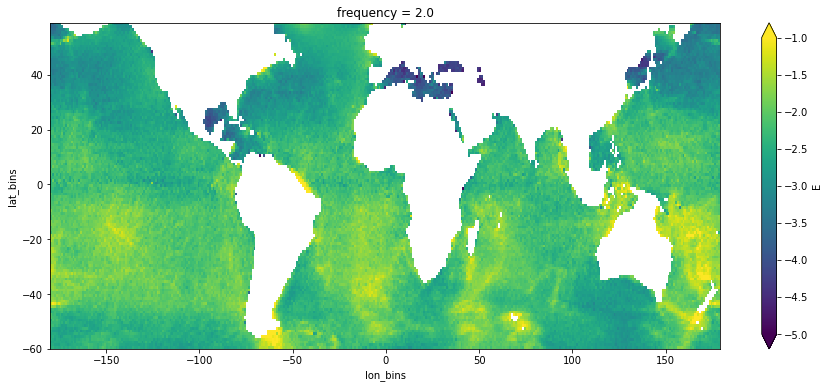

In [5]:
# load spectra
ds = p.load_diagnostic('spectra_uv_T30_mean1_lon_lat.zarr')
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E.sel(frequency=2)).plot(x='lon_bins',cmap='viridis', vmin=-5, vmax=-1)

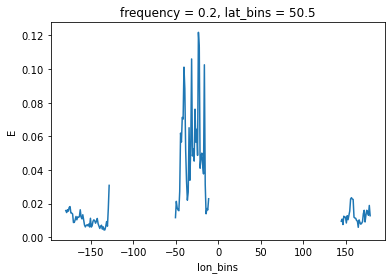

In [6]:
ds = p.load_diagnostic('spectra_uv_T30_mean1_lon_lat.zarr')
ds.E.sel(frequency=.2).isel(lat_bins=110).plot()

__________________
## 2. Zonally averaged spectra (i.e.,1D, as a function of lat) 
### method 2: from 2D binned Lagrangian spectra (i.e. from section 1)
### done by XY

In [7]:
#root_dir = '/home1/datawork/aponte/parcels/'
root_dir = os.path.join(ut.root_data_dir, 'parcels')

run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(os.path.join(root_dir, run_name), 
                      parquets=['trajectory'],
                     )


In [8]:
V = ["T30", "T60", "T90"]

for v in V:

    ds = p.load_diagnostic('spectra_uv_%s_mean1_lon_lat.zarr'%(v))
    E = ds.mean('lon_bins')    
    p.store_diagnostic('spectra_uv_%s_mean1_lat'%(v), E, overwrite=True)
    print('<%s - allready processed>'%(v))        

spectra_uv_T30_mean1_lat diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T30_mean1_lat.zarr
<T30 - allready processed>
spectra_uv_T60_mean1_lat diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat.zarr
<T60 - allready processed>
spectra_uv_T90_mean1_lat diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T90_mean1_lat.zarr
<T90 - allready processed>


In [16]:
ds = p.load_diagnostic('spectra_uv_T30_mean1_lat.zarr')
ds

<xarray.Dataset>
Dimensions:    (frequency: 720, lat_bins: 119)
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.97 -11.93 ... 11.9 11.93 11.97
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    E          (lat_bins, frequency) float64 dask.array<chunksize=(119, 100), meta=np.ndarray>

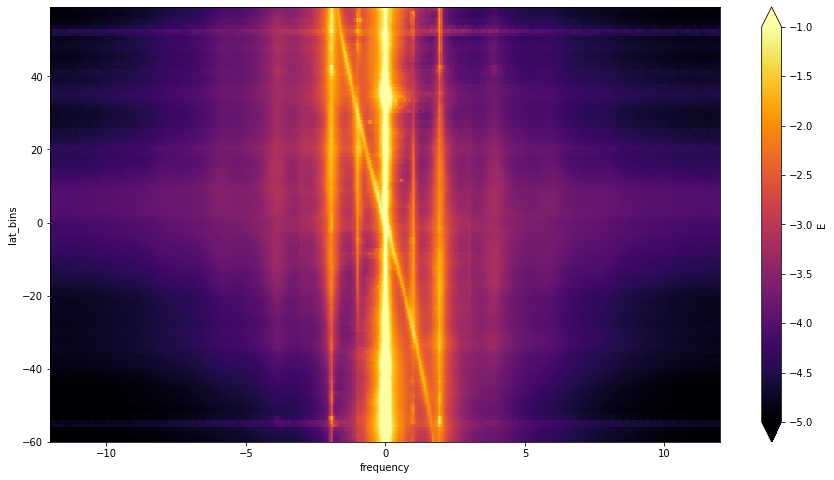

In [10]:
# load
ds = p.load_diagnostic('spectra_uv_T30_mean1_lat.zarr')

fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).plot(x='frequency', vmin=-5, vmax=-1,cmap='inferno')

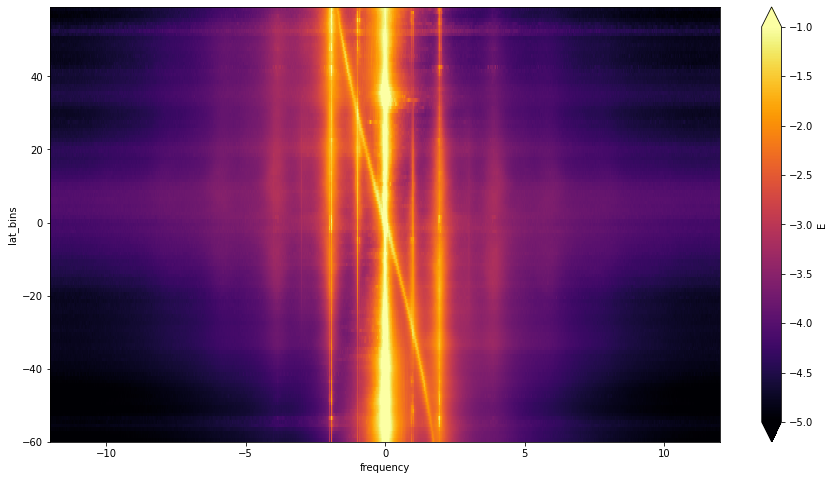

In [11]:
# load
ds = p.load_diagnostic('spectra_uv_T60_mean1_lat.zarr')

fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).plot(x='frequency', vmin=-5, vmax=-1,cmap='inferno')

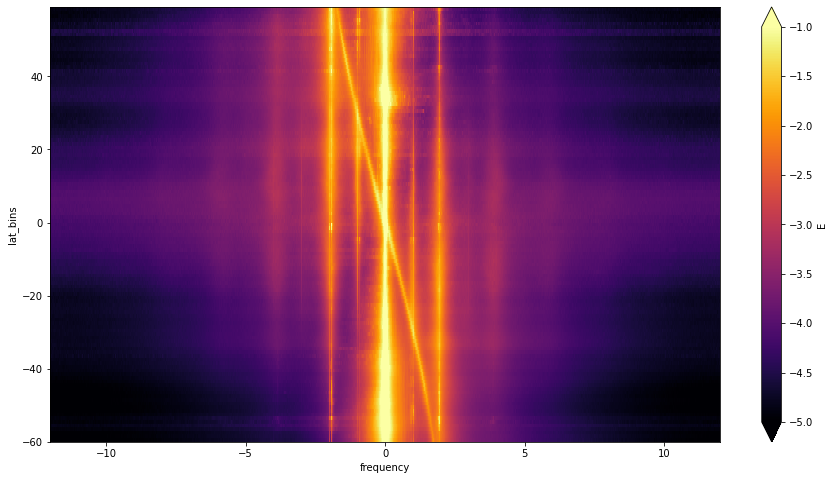

In [12]:
# load
ds = p.load_diagnostic('spectra_uv_T90_mean1_lat.zarr')

fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).plot(x='frequency', vmin=-5, vmax=-1,cmap='inferno')

_____________
# 3. Lagrangian KE maps

## lon x lat for band-integrated KE
### done by XY

In [14]:
V = ["T30", "T60", "T90"]

for v in V:
    
    ds = p.load_diagnostic('spectra_uv_%s_mean1_lon_lat.zarr'%(v))

    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(ds.lat_bins))
    f_cpd_llc = f_llc*86400/2./np.pi

    bands = {'total': (0., 12), 'low': (0., .5), 'supertidal': (2.4, 12),
             'diurnal_0dot1': (0.9, 1.1), 'diurnal_0dot2': (0.8, 1.2), 'diurnal_0dot3': (0.7, 1.3), 'diurnal_0dot4': (0.6, 1.4),
             'semidiurnal_0dot1': (1.9, 2.1), 'semidiurnal_0dot2': (1.8, 2.2), 'semidiurnal_0dot3': (1.7, 2.3), 'semidiurnal_0dot4': (1.6, 2.4),
             'inertial_0dot1':(f_cpd_llc.values.min(),f_cpd_llc.values.max()),'inertial_0dot2':(f_cpd_llc.values.min(),f_cpd_llc.values.max()),
             'inertial_0dot3':(f_cpd_llc.values.min(),f_cpd_llc.values.max()),'inertial_0dot4':(f_cpd_llc.values.min(),f_cpd_llc.values.max())
            }
    
    domega = float(ds.frequency[1]- ds.frequency[0])

    Eb = {}
    for b, bounds in bands.items():
        #print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))

        if b == "inertial_0dot1":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.1), 
                        drop=False,
                       )
        elif b == "inertial_0dot2":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.2), 
                        drop=False,
                       )
        elif b == "inertial_0dot3":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.3), 
                        drop=False,
                       )
        elif b == "inertial_0dot4":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.4), 
                        drop=False,
                       )            
            
        else:
            _E = ds.E.where((np.abs(ds.frequency)>=bounds[0]) & (np.abs(ds.frequency)<=bounds[1]), 
                            drop=False,
                           )

        E = domega * _E.sum('frequency')    
        Eb[b] = E.persist()

    # converts to single dataset and store:
    E = xr.concat(list(Eb.values()), 
                  dim=pd.Index(list(Eb.keys()),name='frequency_band'),
                 )
    
    E = E.where(E>0)
    # store diagnostic
    p.store_diagnostic('spectra_uv_%s_mean1_lat_lon_bands'%(v), E.to_dataset(), overwrite=True)

spectra_uv_T30_mean1_lat_lon_bands diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T30_mean1_lat_lon_bands.zarr
spectra_uv_T60_mean1_lat_lon_bands diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat_lon_bands.zarr
spectra_uv_T90_mean1_lat_lon_bands diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T90_mean1_lat_lon_bands.zarr


In [15]:
ds = p.load_diagnostic('spectra_uv_T30_mean1_lat_lon_bands.zarr')
ds

<xarray.Dataset>
Dimensions:         (frequency_band: 15, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E               (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 119), meta=np.ndarray>

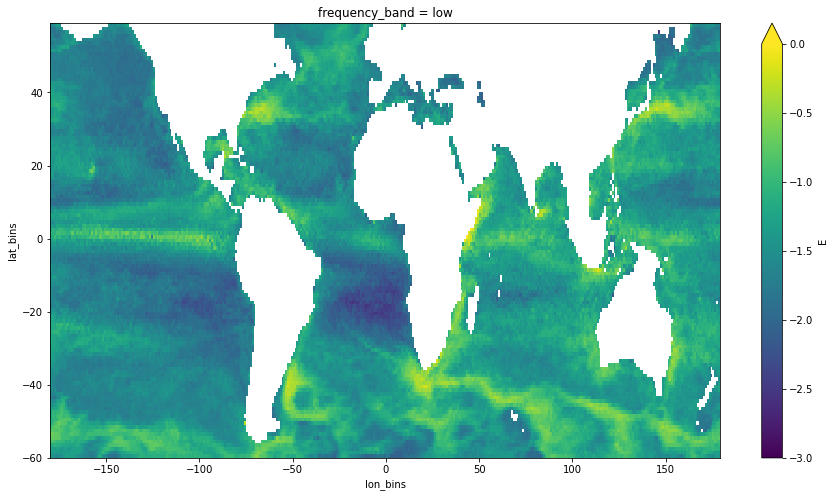

In [18]:
ds = p.load_diagnostic('spectra_uv_T30_mean1_lat_lon_bands.zarr')
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='low').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

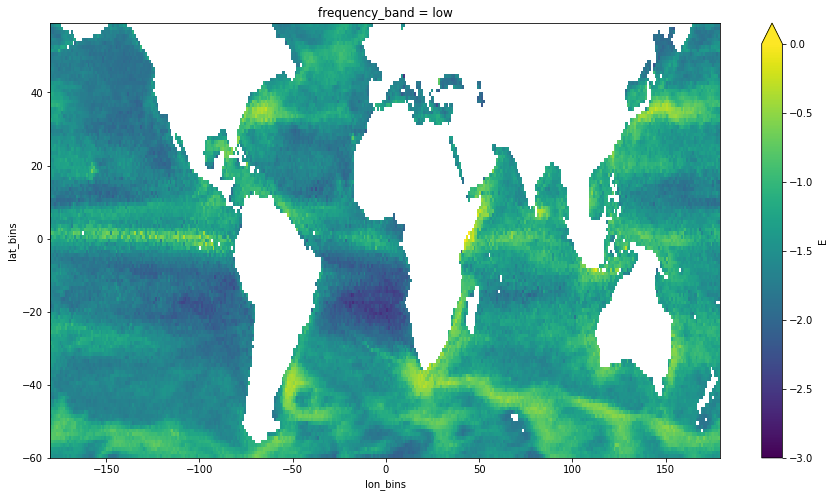

In [16]:
ds = p.load_diagnostic('spectra_uv_T60_mean1_lat_lon_bands.zarr')
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='low').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

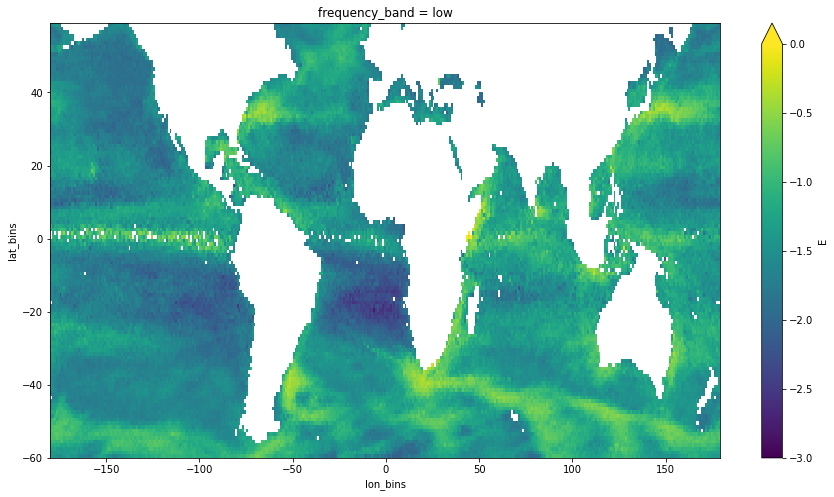

In [17]:
ds = p.load_diagnostic('spectra_uv_T90_mean1_lat_lon_bands.zarr')
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='low').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

## Close cluster

In [14]:
cluster.close()